## Importing Necessary Libraries <a id='libs'></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

import re
import nltk
# nltk.download('wordnet')
# nltk.download('punkt')
# nltk.download('stopwords')

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# !pip install gensim
from gensim.models import Word2Vec

from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV

# !pip install wordcloud
from wordcloud import WordCloud, STOPWORDS

from collections import Counter

## Importing Dataset <a id='data'></a>

In [18]:
url = 'https://raw.githubusercontent.com/krishnaik06/SpamClassifier/master/smsspamcollection/SMSSpamCollection'
df = pd.read_csv(url, sep='\t', names=['label', 'message'])
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## EDA Begins Here...

In [19]:
df.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

Our dataset has **747 spam** and **4825 non-spam** messages.

In [20]:
df['label_num'] = df['label'].map({'ham': 0, 'spam': 1})
df.head()

,label,message,label_num
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


**"1" for SPAM and "0" for HAM**

In [21]:
# Calculating length of messages
df['msg_len'] = df['message'].apply(len)
df.head()

,label,message,label_num,msg_len
0,ham,"Go until jurong point, crazy.. Available only ...",0,111
1,ham,Ok lar... Joking wif u oni...,0,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,ham,U dun say so early hor... U c already then say...,0,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61


Text(0.5, 0, 'Messages Length')

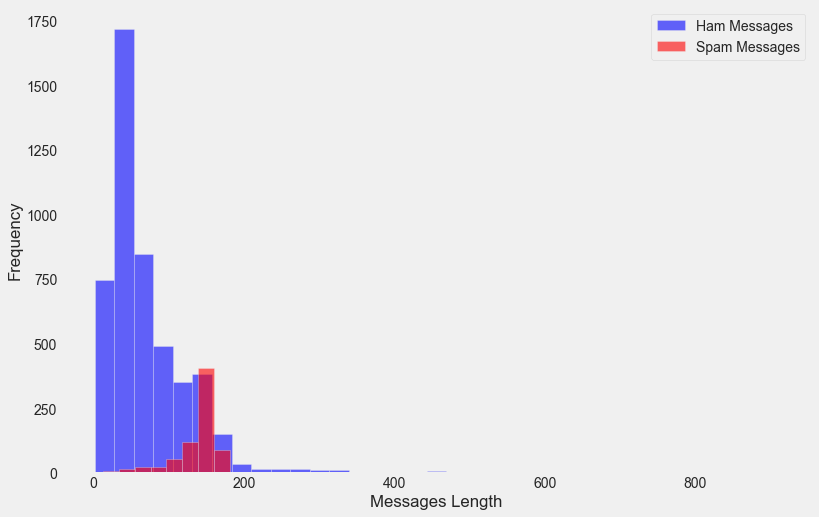

In [22]:
plt.figure(figsize=(12, 8))
df[df['label'] == 'ham']['msg_len'].plot(kind='hist',bins=35, color='blue', label='Ham Messages', alpha=0.6)
df[df['label'] == 'spam']['msg_len'].plot(kind='hist', color='red', label='Spam Messages', alpha=0.6)
plt.legend()
plt.xlabel("Messages Length")

This gives us a useful information, **SPAM messages usually have higher message length.**

In [23]:
df[df['label_num'] == 1]['msg_len'].describe()

count    747.000000
mean     138.670683
std       28.873603
min       13.000000
25%      133.000000
50%      149.000000
75%      157.000000
max      223.000000
Name: msg_len, dtype: float64

In [24]:
df[df['label_num'] == 0]['msg_len'].describe()

count    4825.000000
mean       71.482487
std        58.440652
min         2.000000
25%        33.000000
50%        52.000000
75%        93.000000
max       910.000000
Name: msg_len, dtype: float64

**Mean length of SPAM SMS is close to 140 and that of non-spam SMS is 71. Hence SPAM SMS are usually larger than HAM messages**

## Performing Basic Text-Preprocessing

In [25]:
lemma = WordNetLemmatizer()
filt_msg = []
for i in range(len(df['message'])):
    filt = re.sub('[^a-zA-Z]', ' ', df['message'][i]) # Eliminating punctuations, numbers etc
    filt = filt.lower() # Making all the words lower case
    filt = word_tokenize(filt) # Spliting the message into words
    filt = [lemma.lemmatize(word) for word in filt if word not in stopwords.words('english')] # Eliminating stopwords and Lemmatizing
    filt = " ".join(filt) # Forming the sentence again
    filt_msg.append(filt)
filt_msg[0:5]

['go jurong point crazy available bugis n great world la e buffet cine got amore wat',
 'ok lar joking wif u oni',
 'free entry wkly comp win fa cup final tkts st may text fa receive entry question std txt rate c apply',
 'u dun say early hor u c already say',
 'nah think go usf life around though']

In [26]:
df['filtered msg'] = pd.Series(filt_msg)
df.head()

,label,message,label_num,msg_len,filtered msg
0,ham,"Go until jurong point, crazy.. Available only ...",0,111,go jurong point crazy available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,0,29,ok lar joking wif u oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,155,free entry wkly comp win fa cup final tkts st ...
3,ham,U dun say so early hor... U c already then say...,0,49,u dun say early hor u c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,61,nah think go usf life around though


## Let's look at the most frequent words in SPAM messages

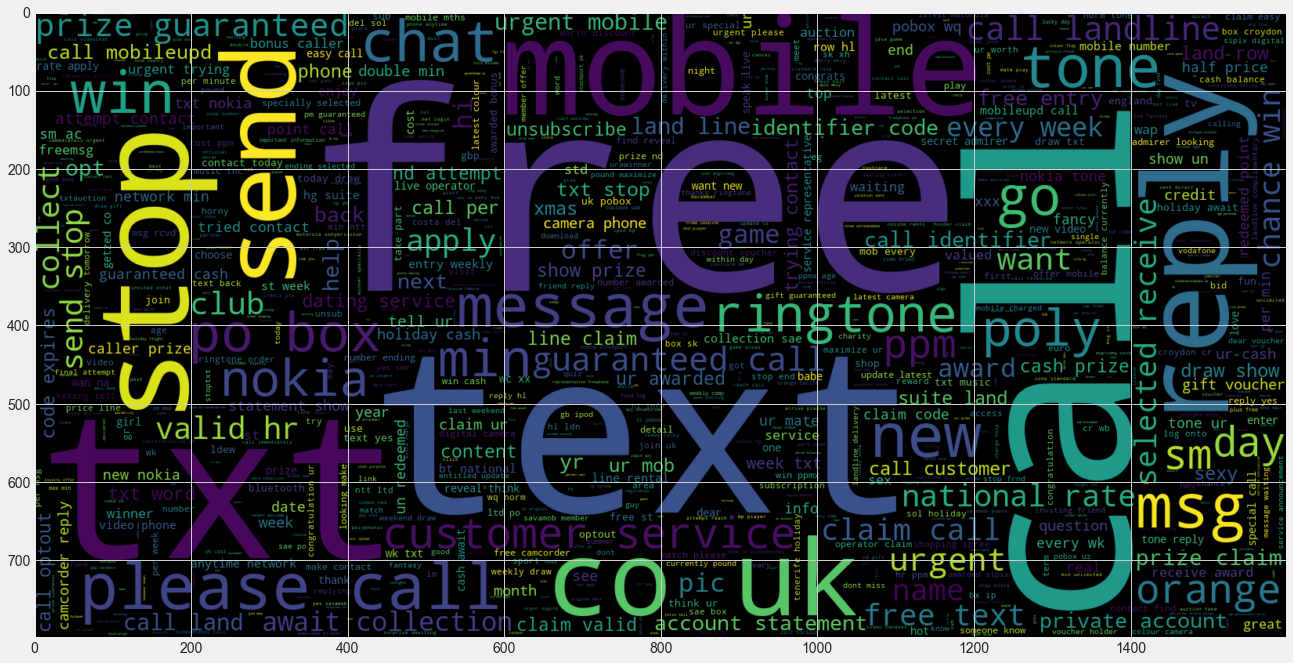

In [11]:
plt.figure(figsize=(20, 20))
wordcloud = WordCloud(max_words=2000, width=1600, height=800, stopwords=STOPWORDS).generate(" ".join(df[df['label_num']==1]['filtered msg']))
plt.imshow(wordcloud, interpolation='bilinear')

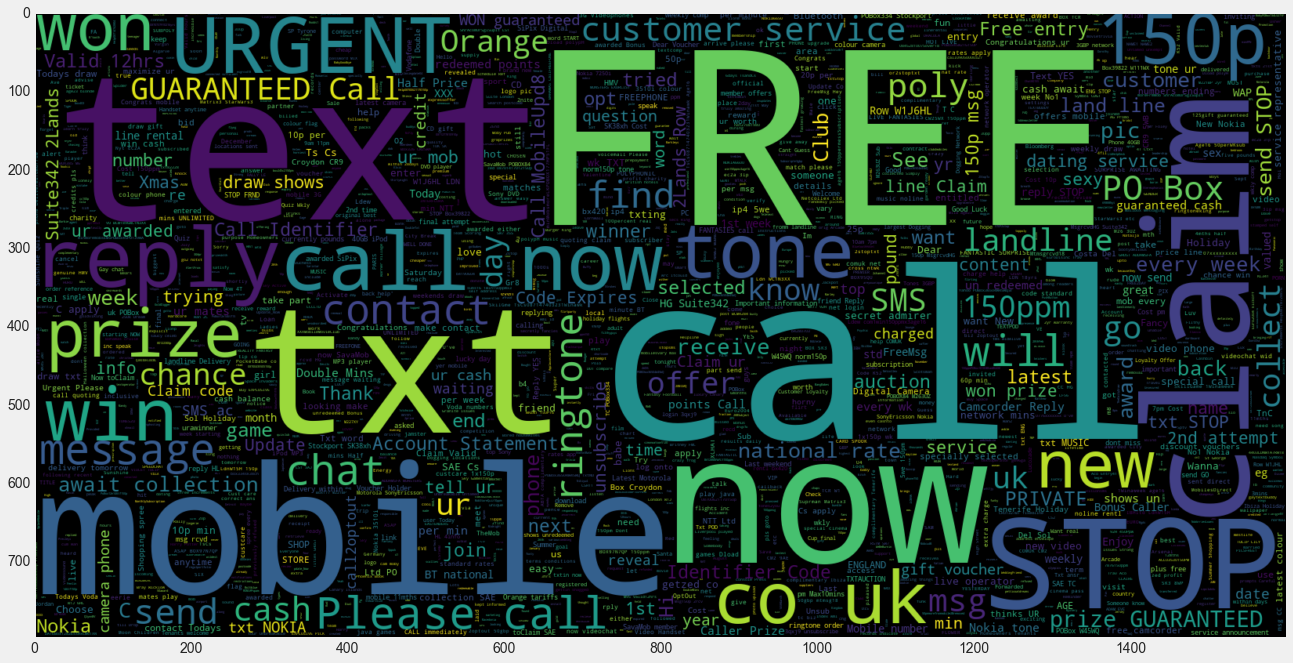

In [27]:
plt.figure(figsize=(20, 20))
wordcloud = WordCloud(max_words=2000, width=1600, height=800, stopwords=STOPWORDS).generate(" ".join(df[df['label_num']==1]['message']))
plt.rcParams['axes.grid'] = False
plt.imshow(wordcloud, interpolation='bilinear')

In [34]:
words = df[df['label'] == 'spam']['filtered msg'].apply(lambda msg: [word for word in msg.split() if word not in ['u', 'p', 'w', 'ur', 'c']])
spam_words = Counter()
for word in words:
    spam_words.update(word)
spam_words = pd.DataFrame(spam_words.most_common(50), columns=['Word', 'Frequency'])
spam_words.head(10)

,Word,Frequency
0,call,388
1,free,228
2,txt,170
3,text,145
4,mobile,142
5,stop,128
6,claim,115
7,reply,106
8,www,98
9,prize,97


In [33]:
words = df[df['label'] == 'ham']['filtered msg'].apply(lambda msg: [word for word in msg.split() if word not in ['u', 'p', 'w', 'ur', 'c']])
ham_words = Counter()
for word in words:
    ham_words.update(word)
ham_words = pd.DataFrame(ham_words.most_common(50), columns=['Word', 'Frequency'])
ham_words.head(10)

,Word,Frequency
0,get,322
1,gt,318
2,lt,316
3,ok,288
4,go,283
5,call,253
6,day,251
7,come,249
8,got,246
9,know,246


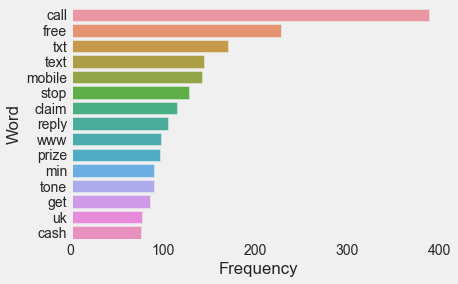

In [45]:
sns.barplot(x='Frequency', y='Word', data=spam_words.head(15))

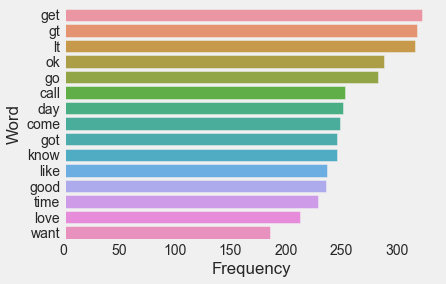

In [46]:
sns.barplot(x='Frequency', y='Word', data=ham_words.head(15))

In [15]:
df.drop(['label', 'message'], axis=1, inplace=True)
df.columns = ['spam', 'msg_length', 'msg']
df.head()

,spam,msg_length,msg
0,0,111,go jurong point crazy available bugis n great ...
1,0,29,ok lar joking wif u oni
2,1,155,free entry wkly comp win fa cup final tkts st ...
3,0,49,u dun say early hor u c already say
4,0,61,nah think go usf life around though


In [16]:
df.to_csv('spam_sms_collection.csv')